# MACD Strategy

The Moving Average Convergence Divergence (MACD) crossover is a technical indicator that uses the difference between exponential moving averages (EMA) to determine the momentum and the direction of the market. 
* MACD=12-Period EMA − 26-Period EMA

In [43]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf

In [44]:
ticker = "INTC"
df = yf.download(ticker)

[*********************100%***********************]  1 of 1 completed


In [45]:
df["short_EMA"] = df.Close.ewm(span=12, adjust=False).mean()
df["long_EMA"] = df.Close.ewm(span=26, adjust=False).mean()
df["MACD"] = df["short_EMA"] - df["long_EMA"]
df["signal"] = df["MACD"].ewm(span=9, adjust=False).mean()

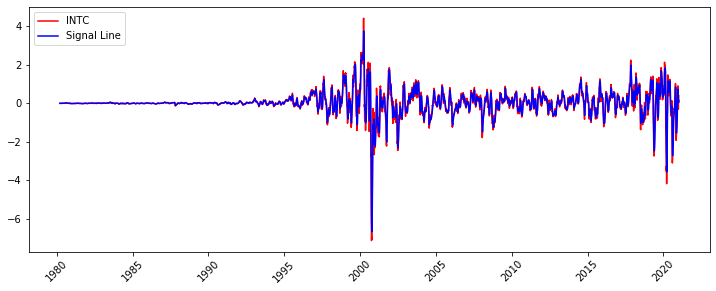

In [46]:
plt.figure(figsize=(12.2,4.5))
plt.plot(df.index, df["MACD"], label=ticker, color = 'red')
plt.plot(df.index, df["signal"], label='Signal Line', color='blue')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()

In [47]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,short_EMA,long_EMA,MACD,signal
Date,,,,,,,,,,
1980-03-17,0.325521,0.330729,0.325521,0.325521,0.200766,10924800,0.325521,0.325521,0.000000,0.000000
1980-03-18,0.325521,0.328125,0.322917,0.322917,0.199160,17068800,0.325120,0.325328,-0.000208,-0.000042
1980-03-19,0.330729,0.335938,0.330729,0.330729,0.203978,18508800,0.325983,0.325728,0.000255,0.000018
1980-03-20,0.330729,0.334635,0.329427,0.329427,0.203175,11174400,0.326513,0.326002,0.000511,0.000116
1980-03-21,0.322917,0.322917,0.317708,0.317708,0.195948,12172800,0.325158,0.325388,-0.000229,0.000047


In [48]:
df["Position"] = 0
df["Action"] = 0
prev = 0
for index, row in df.iterrows():
    if prev == 1:
        df.loc[index,'Position'] = 1
    
    if row.MACD > row.signal and prev == 0:
        df.loc[index,'Position'] = 1
        df.loc[index,'Action'] = 1
        prev = 1
    
    if row.MACD < row.signal and prev == 1:
        df.loc[index,'Position'] = 0
        df.loc[index,'Action'] = -1
        prev = 0

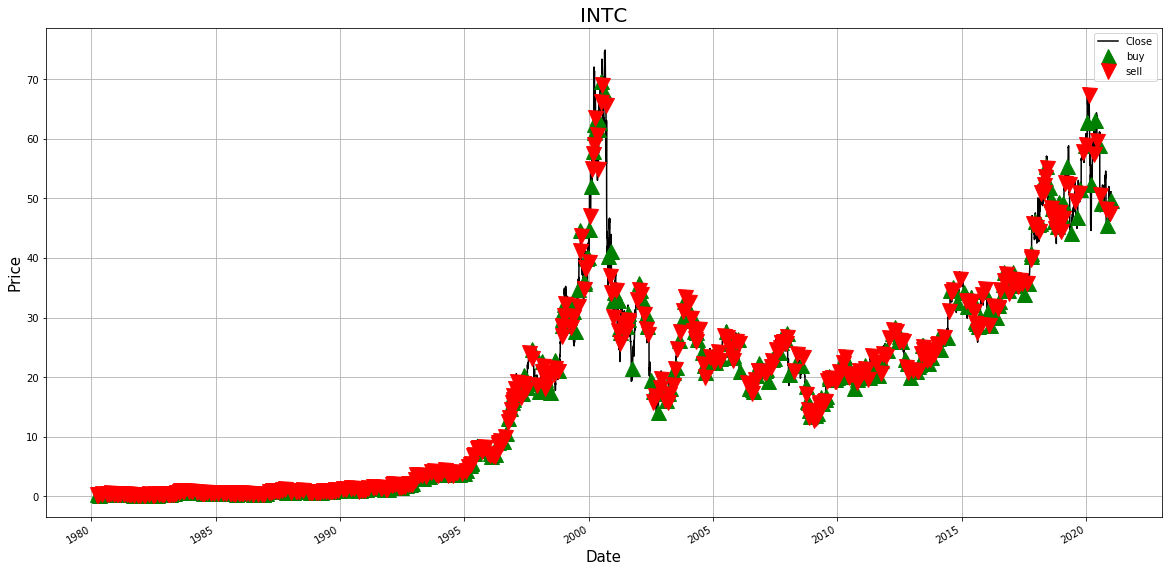

In [49]:
plt.figure(figsize = (20,10))

df["Close"].plot(color = "k", label= "Close")

plt.plot(df[df["Action"] == 1].index, 
         df["Close"][df["Action"] == 1], 
         "^", markersize = 15, color = "g", label = 'buy')

plt.plot(df[df["Action"] == -1].index, 
         df["Close"][df["Action"] == -1], 
         "v", markersize = 15, color = "r", label = 'sell')

plt.ylabel('Price', fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.title(ticker, fontsize = 20)
plt.legend()
plt.grid()
plt.show()

In [50]:
df["Shifted_position"]=df["Position"].shift(1)
asset_log_returns = np.log(df["Open"]).diff()
strategy_asset_log_returns = df["Shifted_position"] * asset_log_returns
cum_strategy_asset_log_returns = strategy_asset_log_returns.cumsum()
cum_MACD_strategy_asset_relative_returns = np.exp(cum_strategy_asset_log_returns) - 1

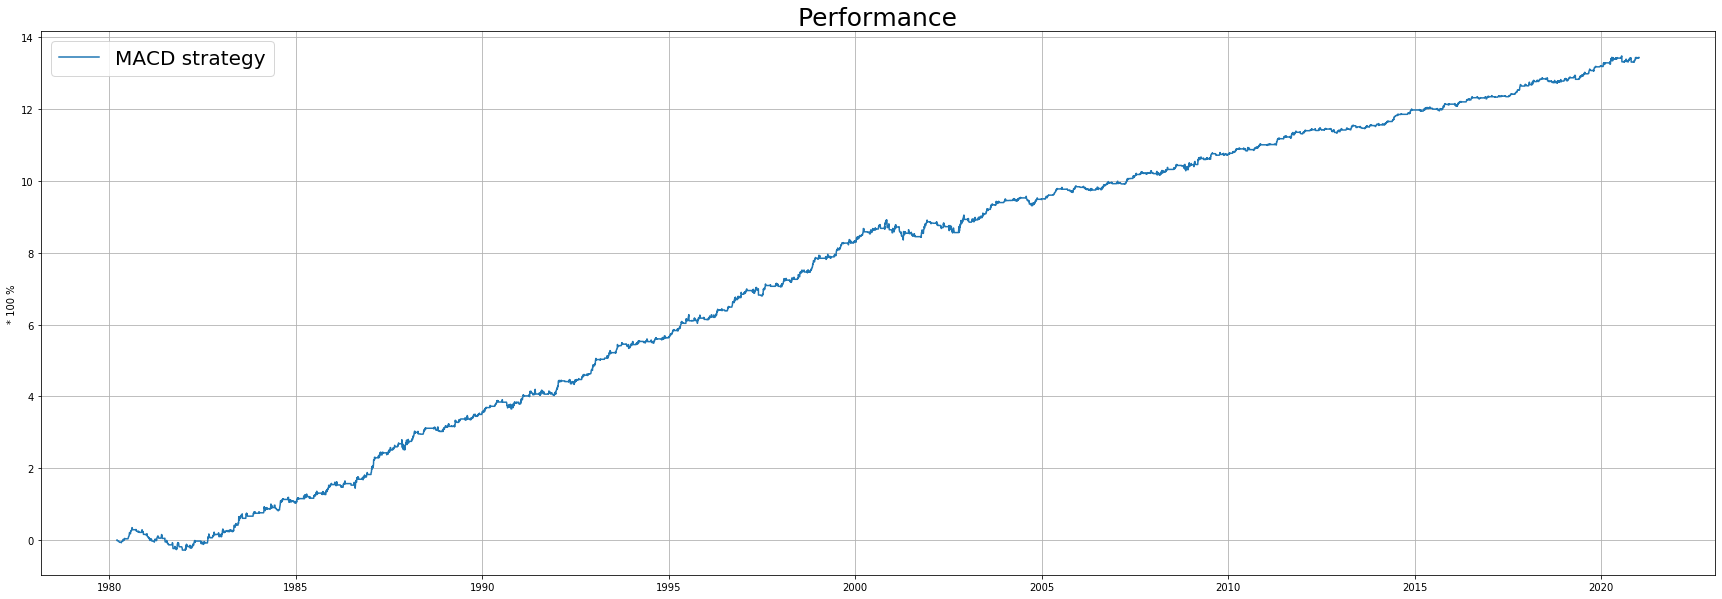

In [51]:
plt.figure(figsize=(30,10))
plt.plot(cum_strategy_asset_log_returns,label="MACD strategy")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.ylabel("* 100 %")
plt.title("Performance", fontsize=25)
plt.show()

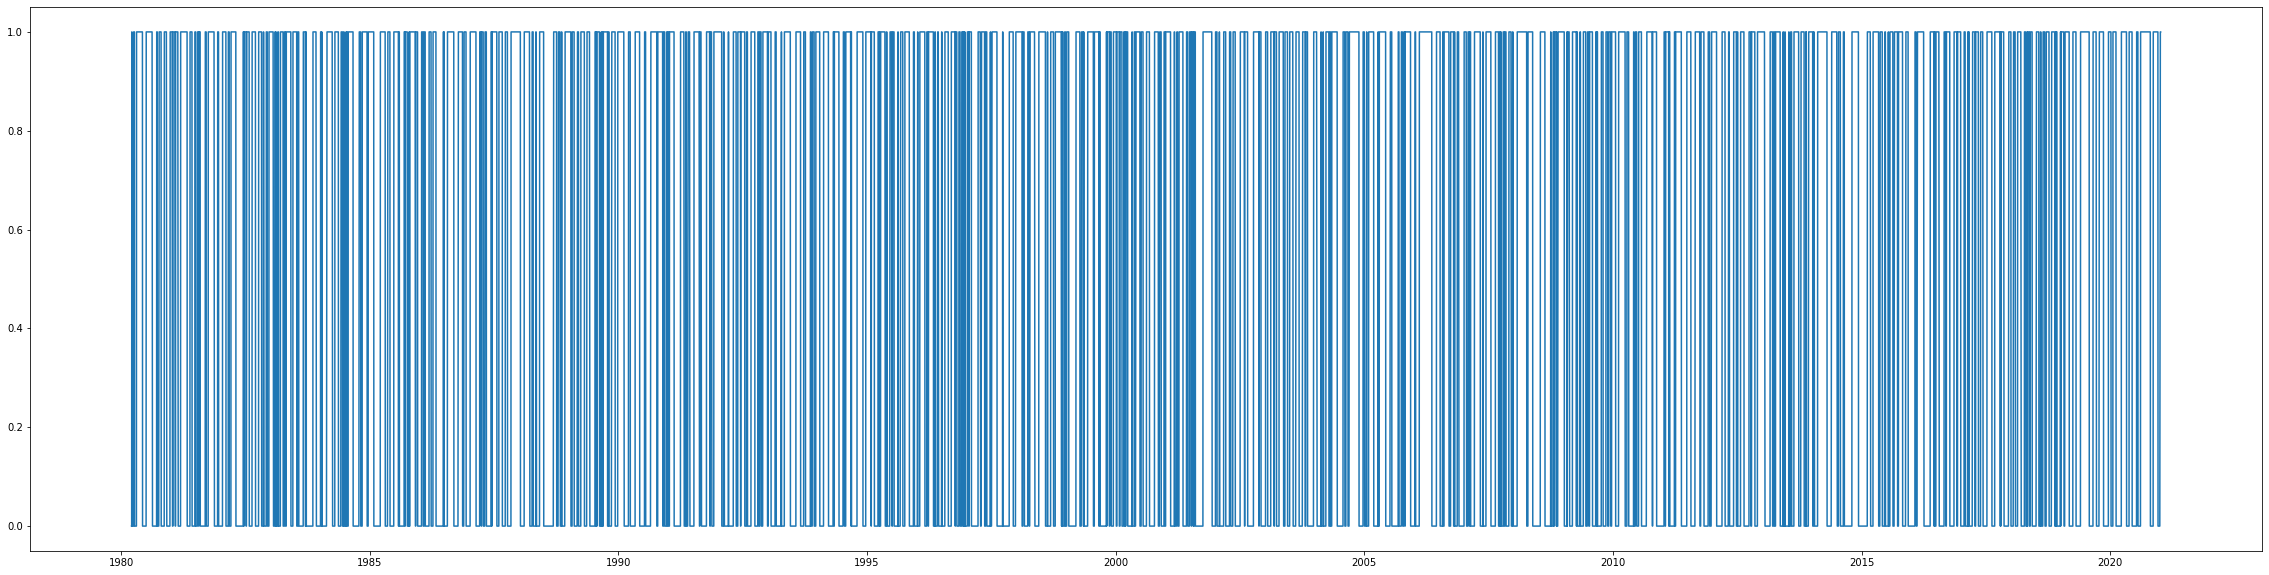

In [52]:
plt.figure(figsize = (40,10))
plt.plot(df["Position"])


In [55]:
df[df.Action == -1].shape[0]

403

In [56]:
trades = []
trade_lengths = []
for i,val in enumerate(strategy_asset_log_returns):
    accumulated_profit = 0
    length = 0
    if i > 0 and val != 0 and strategy_asset_log_returns[i-1] == 0:
        for j in range (i, len(strategy_asset_log_returns)):
            if strategy_asset_log_returns[j] != 0:
                accumulated_profit += strategy_asset_log_returns[i]
                length +=1
            else:
                break
    if accumulated_profit != 0:
        trades.append(accumulated_profit)
        trade_lengths.append(length)

/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Trade length')

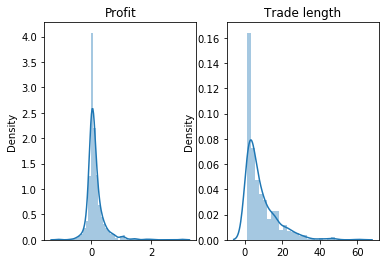

In [57]:
fig,axes=plt.subplots(1,2)
sns.distplot(trades,ax=axes[0])
sns.distplot(trade_lengths,ax=axes[1])
axes[0].set_title("Profit")
axes[1].set_title("Trade length")